# Bayesian Modelling

This notebook is for those interested in learning Bayesian statistics in Python. Much of this material is drawn from Mark Dregan's GitHub: https://github.com/markdregan/Bayesian-Modelling-in-Python. See here for more details.

Statistics often deploys frequentist techniques (such as p-values) and can feel contrived. Thus as an alternative approach we can deploy **Bayesian Statistics** - a branch of statistics quite different from the frequentist approach. 

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import matplotlib.pyplot as plt

%matplotlib inline

## How do Bayesians think about data?

Imagine the following scenario:

> A curious boy watches the number of cars that pass by his house every day. He diligently notes down the total count of cars that pass per day. Over the past week, his notebook contains the following counts: 12, 33, 20, 29, 20, 30, 18.

From a Bayesian's perspective, the data is generated by a random process. However, now that the data is observed, it is fixed and does not change. This random process has some model parameters that are fixed. However, the Bayesian uses probability distributions to represent their *uncertainty* in these parameters.

Because the boy is measuring counts (non-negative integers), it is common practice to use a Poisson distribution to model the data (e.g the random process). A Poisson distribution takes a single parameter $\mu$ which describes both the mean and variance of the data. You can see 3 Poisson distributions below with different values of $\mu$:

$$
p(x | \mu) = \frac{e^{-\mu}\mu^x}{x!}, \quad x = 0,1,2,\dots \\
\lambda = E(x) = Var(\mu)
$$

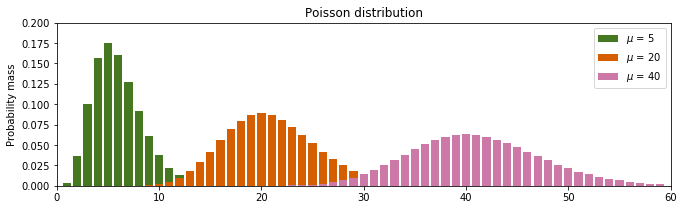

In [2]:
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

fig = plt.figure(figsize=(11,3))
ax = fig.add_subplot(111)
x_lim = 60
mu = [5, 20, 40]
for i in np.arange(x_lim):
    plt.bar(i, stats.poisson.pmf(mu[0], i), color=colors[3])
    plt.bar(i, stats.poisson.pmf(mu[1], i), color=colors[4])
    plt.bar(i, stats.poisson.pmf(mu[2], i), color=colors[5])
    
_ = ax.set_xlim(0, x_lim)
_ = ax.set_ylim(0, 0.2)
_ = ax.set_ylabel('Probability mass')
_ = ax.set_title('Poisson distribution')
_ = plt.legend(['$\mu$ = %s' % mu[0], '$\mu$ = %s' % mu[1], '$\mu$ = %s' % mu[2]])

Here we will work with some *Google Hangout Chat* data, where we are interested in modelling the time it takes to respond to messages. Given that `response_time` is count data, we can model it as a Poisson distribution and estimate it's parameter $\mu$.

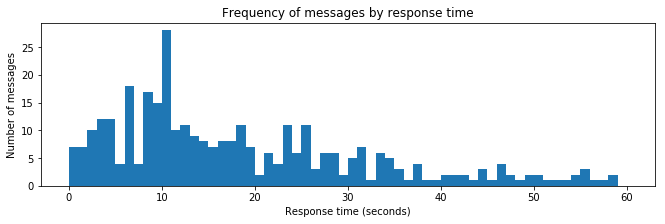

In [3]:
messages = pd.read_html("hangout_chat_data.csv")[0]

fig = plt.figure(figsize=(11,3))
_ = plt.title('Frequency of messages by response time')
_ = plt.xlabel('Response time (seconds)')
_ = plt.ylabel('Number of messages')
_ = plt.hist(messages['time_delay_seconds'].values, 
             range=[0, 60], bins=60, histtype='stepfilled')

## The Frequentist Approach

Before we jump into Bayesian techniques, let's analyse a frequentist method of estimating $\mu$. We will use an optimization technique that *maximises* the likelihood of a function.

Our function `poisson_logprob()` returns the overall likelihood of the observed data given a Poisson model and parameter value. We use the method `scipy.optimize.minimize_scalar` to find the value of $\mu$ that is most credible given the data observed. 

In [4]:
from scipy import optimize as opt

y_obs = messages["time_delay_seconds"].values

def poisson_logprob(mu, sign=-1):
    return np.sum(sign*stats.poisson.logpmf(y_obs, mu=mu))

freq_res = opt.minimize_scalar(poisson_logprob)
%time print("The estimated value of mu is: %s" % freq_res['x'])

The estimated value of mu is: 18.2307692323807
CPU times: user 173 µs, sys: 12 µs, total: 185 µs
Wall time: 165 µs


The drawback with this method is that the optimization provides no measure of *uncertainty* - it just returns a point value. And it does so efficiently.

Below we illustrate the optimization the function is performing: at each value of $\mu$, the plot shows the log probability of $\mu$ given the data and the model. The optimizer hill-climbs starting at a random point on the curve and incrementally climbs until it cannot reach a higher point. This is known as finding the *local maxima*.

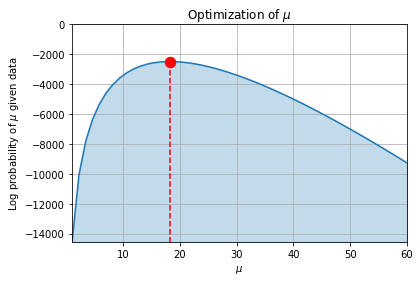

In [5]:
x = np.linspace(1, 60)
y_min = np.min([poisson_logprob(i, sign=1) for i in x])
y_max = np.max([poisson_logprob(i, sign=1) for i in x])
fig = plt.figure(figsize=(6,4))
_ = plt.plot(x, [poisson_logprob(i, sign=1) for i in x])
_ = plt.fill_between(x, [poisson_logprob(i, sign=1) for i in x], 
                     y_min, color=colors[0], alpha=0.3)
_ = plt.title('Optimization of $\mu$')
_ = plt.xlabel('$\mu$')
_ = plt.ylabel('Log probability of $\mu$ given data')
_ = plt.vlines(freq_res['x'], y_max, y_min, colors='red', linestyles='dashed')
_ = plt.scatter(freq_res['x'], y_max, s=110, c='red', zorder=3)
_ = plt.ylim(bottom=y_min, top=0)
_ = plt.xlim(left=1, right=60)
_ = plt.grid()

The above optimization estimated the parameter $\mu$ to be 18. We know for any Poisson distribution, the parameter $\mu$ represents the mean and it's variance.

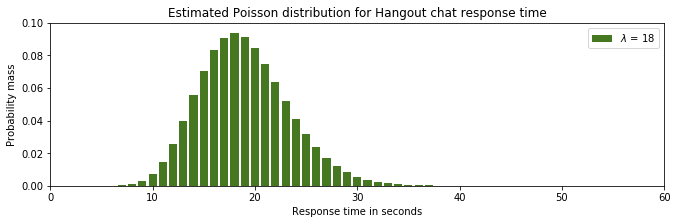

In [6]:
fig = plt.figure(figsize=(11,3))
ax = fig.add_subplot(111)
x_lim = 60
mu = np.int(freq_res['x'])
for i in np.arange(x_lim):
    plt.bar(i, stats.poisson.pmf(mu, i), color=colors[3])
    
_ = ax.set_xlim(0, x_lim)
_ = ax.set_ylim(0, 0.1)
_ = ax.set_xlabel('Response time in seconds')
_ = ax.set_ylabel('Probability mass')
_ = ax.set_title('Estimated Poisson distribution for Hangout chat response time')
_ = plt.legend(['$\lambda$ = %s' % mu])

With the above Poisson model providing a variance of values between 10 and 30, this doesn't accurately reflect the distribution we observe in the actual data - which has observed values in the range 0 to 60.

## Bayesian Method of estimating $\mu$

To estimate using a Bayesian Method, it would be important to first cover **Bayes' Theorem**. This states that the *posterior distribution*, i.e the probability of the parameter $\mu$ given the data is related to the probability distribution of the data, given the parameter multiplied by some prior distribution:

$$
P(A|B)=\frac{P(B|A) P(A)}{P(B)}
$$

where $A$ and $B$ are events and $P(B) \neq 0$. 

- $P(A|B)$ is the conditional probability of the likelihood of event $A$ happening given that $B$ is true.
- $P(B|A)$ is the conditional probability of the likelihood of event $B$ happening given that $A$ is true.
- $P(A)$ and $P(B)$ are the probabilities of observing $A$ and $B$ independently of each other; these are known as marginal probabilities.

In our case, $A=\mu$ and $B=X$, where $X$ is our data referring to response time in seconds.

Our model, is as follows:

1. Draw a prior from the Uniform distribution: $\mu \sim \mathcal{U}(0, 60)$
2. Represent data as a Poisson distribution (likelihood) with single parameter $\mu$: $y_i \sim \text{Poisson}(\mu)$

## The mechanics of MCMC

The process of Markov Chain Monte Carlo (MCMC) sampling draws parameter values from the prior distribution and computes the likelihood that the observed data came from a distribution with these parameter values.

$$
P(\mu | X) \propto P(X | \mu)P(\mu)
$$

This calculation acts as a guiding light for the MCMC sampler. As it draws values from the parameter priors, it computes the likelihood of these parameters given the data - and will try to guide the sampler towards areas of higher probability. 

The MCMC sampler *wanders* towards areas of highest likelihood. However, the Bayesian method is not concerned with finding the absolute maximum values - but rather to traverse and collect samples around the area of highest probability. All of the samples collected are considered to be a credible parameter.

In [7]:
with pm.Model() as model:
    # draw mu from a uniform distribution
    mu = pm.Uniform("mu", lower=0, upper=60)
    # likelihood follows a Poisson distribution - we think
    likelihood = pm.Poisson("likelihood", mu=mu, observed=y_obs)
    # use maximum a posteriori estimate for start initial guess
    start = pm.find_MAP()
    # use metropolis algorithm
    step = pm.Metropolis()
    # generate
    trace = pm.sample(50000, step, start=start, progressbar=True)

logp = -3,398.7, ||grad|| = 1,989: 100%|██████████| 7/7 [00:00<00:00, 2700.28it/s]
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mu]
Sampling 4 chains: 100%|██████████| 402000/402000 [00:31<00:00, 12945.81draws/s]
The number of effective samples is smaller than 10% for some parameters.


/home/gparkes/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


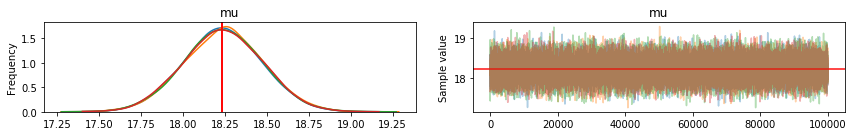

In [8]:
_ = pm.traceplot(trace, varnames=["mu"], lines={"mu":freq_res['x']})

The above has just gathered 100000 credible samples of $\mu$ by traversing over the areas of high likelihood of the posterior distribution of $\mu$. The below plot (left) shows the distribution of collected values over $\mu$. The mean of this distribution is identical (almost) to the frequentist estimate (red line). We also get a measure of uncertainty and can see there are credible values of $\mu \in [17,19]$. This measure of uncertainty is incredibly valuable.

## Discarding early samples (burnin)

You may have wondered what `pm.find_MAP()` does in the above MCMC code. MAP stands for maximum a posteriori estimation. It helps the MCMC sampler find a good place to start sampling. Ideally this will start the model off in an area of high likelihood - although nothing is guaranteed with local maxima issues. As a result, samples collected early in the trace are often discarded.

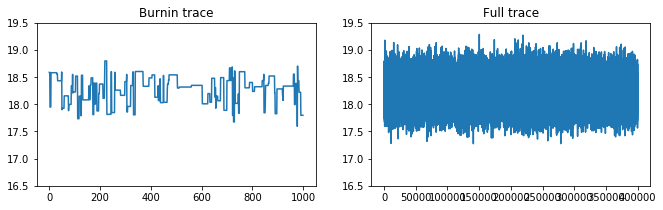

In [9]:
fig = plt.figure(figsize=(11,3))
plt.subplot(121)
_ = plt.title('Burnin trace')
_ = plt.ylim(bottom=16.5, top=19.5)
_ = plt.plot(trace.get_values('mu')[:1000])
fig = plt.subplot(122)
_ = plt.title('Full trace')
_ = plt.ylim(bottom=16.5, top=19.5)
_ = plt.plot(trace.get_values('mu'))

## Model convergence

### Trace

Just because the above model estimated a value for μ, doesn't mean the model estimated a good value given the data. There are some recommended checks that you can make. Firstly, look at the trace output. You should see the trace jumping around and generally looking like a hairy caterpillar. If you see the trace snake up and down or appear to be stuck in any one location - it is a sign that you have convergence issues and the estimations from the MCMC sampler cannot be trusted.

### Autocorrelation plot

The second test you can perform is the autocorrelation test (see below plot). It is a measure of correlation between successive samples in the MCMC sampling chain. When samples have low correlation with each other, they are adding more "information" to the estimate of your parameter value than samples that are highly correlated.

Visually, you are looking for an autocorrelation plot that tapers off to zero relatively quickly and then oscilates above and below zero correlation. If your autocorrelation plot does not taper off - it is generally a sign of poor mixing and you should revisit your model selection (eg. likelihood) and sampling methods (eg. Metropolis).

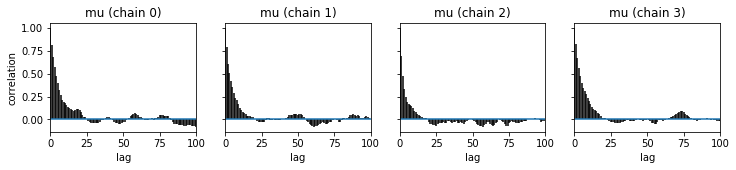

In [10]:
_ = pm.autocorrplot(trace[:2000], varnames=["mu"])

## Model Checking

For checking whether a model is suitable for fitting the data, we can ask two questions:

1. Are the model and parameters estimated a good fit for the underlying data?
2. Given two separate models, which is a better fit for the underlying data?

### Model Check I: Posterior predictive check

Where in the previous model, we drew 100000 samples from the posterior distribution of $\mu$, we generate *new* data from the predicted model. What this means is we construct 100000 Poisson distributions with these values of $\mu$ and then randomly sample from these distributions, formally constructed as:

$$
P(\hat{y}|y)=\int P(\hat{y}|\theta)f(\theta|y)d\theta
$$

Conceptually, if the model is a good fit for the underlying data then the generated data should resemble the original observed data. PyMC provides a convenient way to sample from the fitted model:

```python
y_pred = pm.Poisson('y_pred', mu=mu)
```

This is almost identical to `y_est` except we do not provide the observed data. PyMC considers this a stochastic node and as the MCMC sampler runs - it also samples data from `y_est`.

In [11]:
with pm.Model() as model:
    mu = pm.Uniform("mu", lower=0, upper=100)
    # likelihood data
    y_est = pm.Poisson("y_est", mu=mu, observed=y_obs)
    # create predicted!
    y_pred = pm.Poisson("y_pred", mu=mu)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(50000, step, start=start, progressbar=True)

logp = -7,014.3, ||grad|| = 5,369: 100%|██████████| 8/8 [00:00<00:00, 2545.28it/s]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [y_pred]
>Metropolis: [mu]
Sampling 4 chains: 100%|██████████| 402000/402000 [00:42<00:00, 9456.66draws/s] 
The number of effective samples is smaller than 10% for some parameters.


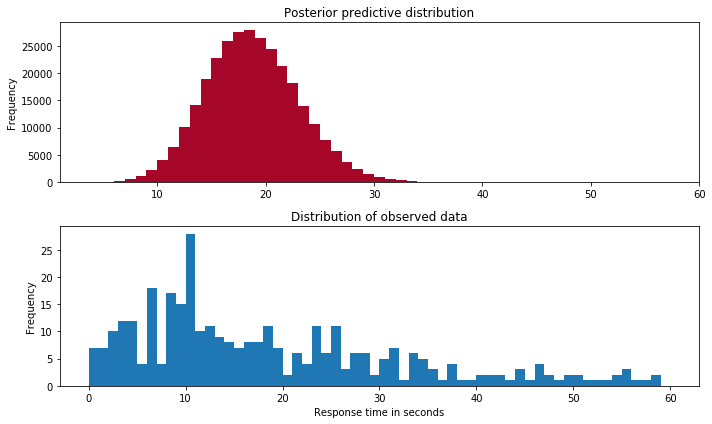

In [12]:
x_lim = 60
burnin=15000
y_pred = trace[burnin:].get_values("y_pred")
mu_mean = trace[burnin:].get_values("mu").mean()

fig = plt.figure(figsize=(10,6))
fig.add_subplot(211)

_ = plt.hist(y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(y_obs, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

## Choosing the right distribution

In this case, it's clear the Poisson distribution is doing a poor job of representing our observed data, no matter how much we tweak the parameters. However, let's try the Negative Binomial distribution, which has similar characteristics to the Poisson distribution except that it has two parameters ($\mu$ and $\alpha$) which enables it to vary its variance independently of it's mean. We compare like so:

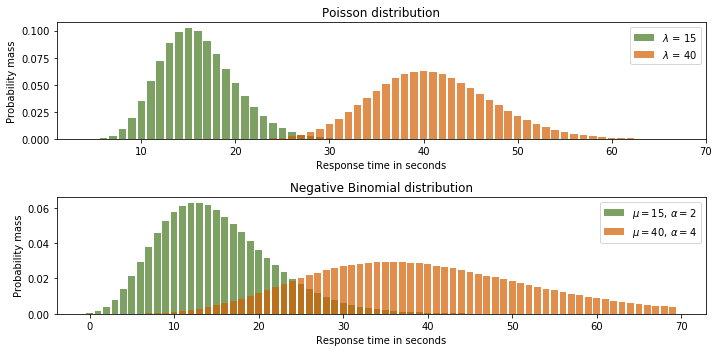

In [13]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(211)
x_lim = 70
mu = [15, 40]
for i in np.arange(x_lim):
    plt.bar(i, stats.poisson.pmf(mu[0], i), color=colors[3], alpha=.7)
    plt.bar(i, stats.poisson.pmf(mu[1], i), color=colors[4], alpha=.7)
    
_ = plt.xlim(1, x_lim)
_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Probability mass')
_ = plt.title('Poisson distribution')
_ = plt.legend(['$\lambda$ = %s' % mu[0],
                '$\lambda$ = %s' % mu[1]])

# Scipy takes parameters n & p, not mu & alpha
def get_n(mu, alpha):
    return 1. / alpha * mu

def get_p(mu, alpha):
    return get_n(mu, alpha) / (get_n(mu, alpha) + mu)

fig.add_subplot(212)
a = [2, 4]
for i in np.arange(x_lim):
    plt.bar(i, stats.nbinom.pmf(i, n=get_n(mu[0], a[0]), p=get_p(mu[0], a[0])), color=colors[3], alpha=.7)
    plt.bar(i, stats.nbinom.pmf(i, n=get_n(mu[1], a[1]), p=get_p(mu[1], a[1])), color=colors[4], alpha=.7)

_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Probability mass')
_ = plt.title('Negative Binomial distribution')
_ = plt.legend(['$\\mu = %s, \/ \\alpha = %s$' % (mu[0], a[0]),
                '$\\mu = %s, \/ \\alpha = %s$' % (mu[1], a[1])])

plt.tight_layout()

Let's try again to estimate the parameters using a Negative Binomial distribution given the same dataset used before. Again, we will use a Uniform distribution to estimate both $\mu$ and $\alpha$. The model can be represented as:

$$
y_j \sim \text{NegBinomial}(\mu, \alpha) \\
\alpha \sim \text{Exponential}\left(\frac{1}{5}\right) \\
\mu \sim \mathcal{U}(0, 100)
$$

In [14]:
with pm.Model() as model:
    
    alpha = pm.Exponential("alpha", lam=.2)
    mu = pm.Uniform("mu", lower=0, upper=100)
    y_pred = pm.NegativeBinomial("y_pred", mu=mu, alpha=alpha)
    y_est = pm.NegativeBinomial("y_est", mu=mu, alpha=alpha, observed=y_obs)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(100000, step, start=start, progressbar=True)

logp = -1,756.7, ||grad|| = 589.95: 100%|██████████| 11/11 [00:00<00:00, 2693.84it/s]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [y_pred]
>Metropolis: [mu]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 402000/402000 [01:05<00:00, 6116.30draws/s]
The number of effective samples is smaller than 10% for some parameters.


/home/gparkes/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


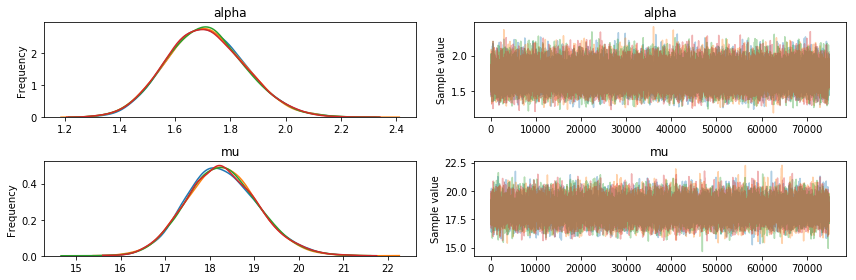

In [15]:
_ = pm.traceplot(trace[burnin:], varnames=["alpha", "mu"])

We can see that the model we have just developed has *less uncertainty* around the estimation of $\mu$ than the Poisson distribution model. 

- Poisson: 10 to 30
- Negative Binomial: 16 to 21

Additionally, the Negative Binomial model has an $\alpha$ parameter of 1.2 to 2.2 which further increases the variance in estimated parameter $\mu$. Let's look at the posterior predictive distribution and see if it more closely resembles the distribution from the observed data.

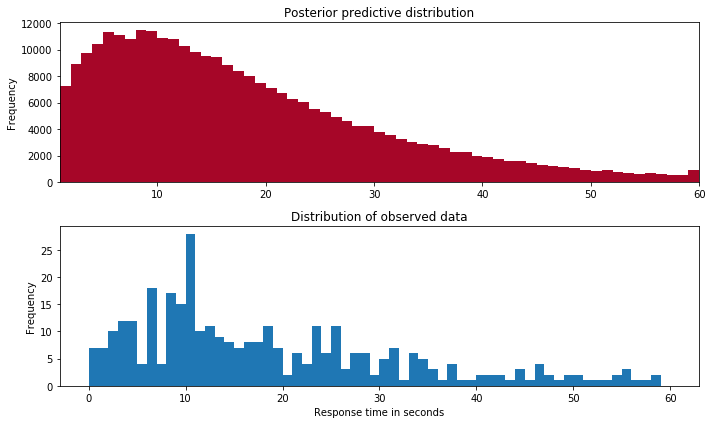

In [16]:
x_lim = 60
y_pred = trace[burnin:].get_values('y_pred')

fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(211)

_ = plt.hist(y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

ax2 = fig.add_subplot(212)

_ = plt.hist(messages['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

These two distributions are looking more similar to one another. As per the posterior predictive check. this would suggest that the Negative binomial model is a more appropriate fit for the underlying data.

We may wish to deploy a more rigorous approach to model checking however; bring forth the **Bayes Factor**.

### Model Check II: Bayes Factor

Another modeling technique is to compute the Bayes factor. This is an analytical method that aims to compare two models with each other.

The Bayes factor was typically a difficult metric to compute because it required integrating over the full joint probability distribution. In a low dimension space, integration is possible but once you begin to model in even modest dimensionality, integrating over the full joint posterior distribution becomes computationally costly and time-consuming.

There is an alternative and analogous technique for calculating the Bayes factor. It involves taking your two models for comparison and combining them into a hierarchical model with a model parameter index ($\tau$
). This index will switch between the two models throughout the MCMC process depending on which model it finds more credible. As such, the trace of the model index tells us a lot about the credibility of model M1 over model M2.

Our new model is as follows:

$$
\tau \sim \text{Bernoulli}\left(\frac{1}{2}\right) \\
\mu_p \sim \mathcal{U}(0, 60) \\
\alpha \sim \text{Exponential}(0.2) \\
\mu_{nb} \sim \mathcal{U}(0, 60) \\
y_j \sim \text{switch}\left(\tau, \text{Poisson}(\mu_p), \text{NegBinomial}(\mu_{nb}, \alpha) \right)\\
$$

In [20]:
with pm.Model() as model:
    prior_model_prob = .5
    # tau from bernoulli
    tau = pm.Bernoulli("tau", prior_model_prob)
    # poisson parameters
    mu_p = pm.Uniform("mu_p", 0, 60)
    # neg binomial parameters
    alpha = pm.Exponential("alpha", lam=.2)
    mu_nb = pm.Uniform("mu_nb", 0, 60)
    # likelihood
    y_like = pm.DensityDist("y_like",
        lambda value: pm.math.switch(
            tau,
            pm.Poisson.dist(mu_p).logp(value),
            pm.NegativeBinomial.dist(mu_nb, alpha).logp(value)
        ),
        observed=y_obs
    )
    
    start = pm.find_MAP()
    step1 = pm.Metropolis([mu_p, alpha, mu_nb])
    step2 = pm.ElemwiseCategorical(vars=[tau], values=[0,1])
    trace = pm.sample(50000, step=[step1,step2], start=start, progressbar=True)

logp = -1,468.5, ||grad|| = 295.67: 100%|██████████| 8/8 [00:00<00:00, 1986.06it/s]
/home/gparkes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [mu_nb]
>>Metropolis: [alpha]
>>Metropolis: [mu_p]
>ElemwiseCategorical: [tau]
Sampling 4 chains: 100%|██████████| 202000/202000 [00:41<00:00, 4829.24draws/s]
The number of effective samples is smaller than 10% for some parameters.


/home/gparkes/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


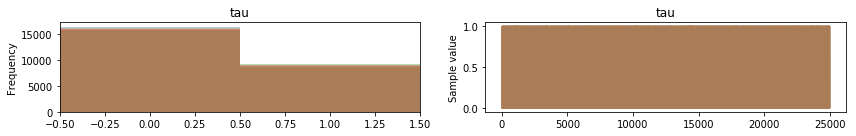

In [21]:
_ = pm.traceplot(trace[burnin:], varnames=['tau'])

We can calculate the **Bayes Factor** for the above two models using the formulation below:

$$
\frac{P(X | M_1)}{P(X | M_2)} = F_B\frac{P(M_1)}{P(M_2)}
$$

where $F_B$ is the Bayes Factor. In the above example, we didn't apply prior probability to either model, hence the Bayes Factor is simply the quotient of the model likelihoods. If you find that your MCMC sampler is not traversing between the two models, you can introduce prior probabilities that will help you get sufficient exposure to both models.

In [22]:
def bayes_factor(tr, burnin=15000, prior_model_prob=0.5):
    prob_pois = tr[burnin:]["tau"].mean()
    prob_nb = 1 - prob_pois
    BF = (prob_nb/prob_pois)*(prior_model_prob/(1-prior_model_prob))
    return BF

In [23]:
print("Bayes Factor: %s" % (bayes_factor(trace)))

Bayes Factor: 1.8229790494626261


A Bayes Factor of $>1$ suggests that $M_1$ (negative binomial) is more strongly supported by the data than $M_2$ (Poisson). Jeffreys' scale of evidence for Bayes factors interprets a BF of 1.6 as there being weak evidence of $M_1 > M_2$ given the data.

| ------------- Bayes Factor ------------- | --------- Interpretation  ------------|
| ------------------------------------ | ------------------------------------- |
|  $F_B(M_1, M_2) < 1/10$  | Strong evidence for $M_2$ |
| $1/10 \lt F_B(M_1, M_2) < 1/3$ | Moderate evidence for $M_2$ |
| $1/3 \lt F_B(M_1, M_2) < 1$ | Weak evidence for $M_2$ |
| $1 \lt F_B(M_1, M_2) < 3$ | Weak evidence for $M_1$ |
| $3 \lt F_B(M_1, M_2) < 10$ | Moderate evidence for $M_1$ |
| $F_B(M_1, M_2) > 10$ | Strong evidence for $M_1$ |

## Hierarchical Modelling

A key strength of Bayesian modelling is the easy and flexibility with which one can implement a hierarchical model.

### Model Pooling

Let's explore a different way of modeling the response time for my hangout conversations. My intuition would suggest that my tendency to reply quickly to a chat depends on who I'm talking to. I might be more likely to respond quickly to someone I care about than to a distant friend. As such, I could decide to model each conversation independently, estimating parameters $\mu_i$ and $\alpha_i$ for each conversation $i$.

One consideration we must make, is that some conversations have very few messages compared to others. As such, our estimates of response time for conversations with few messages will have a higher degree of uncertainty than conversations with a large number of messages. The below plot illustrates the discrepancy in sample size per conversation.

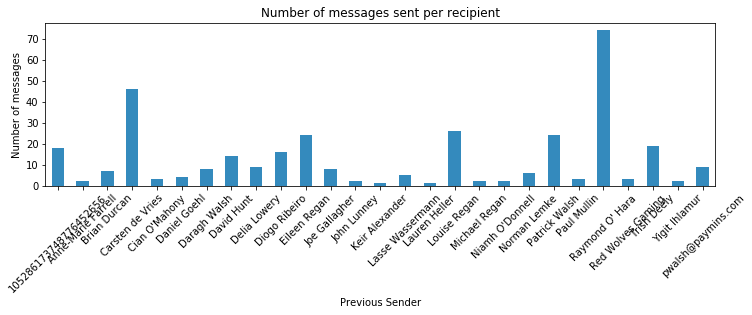

In [24]:
ax = messages.groupby('prev_sender')['conversation_id'].size().plot(
    kind='bar', figsize=(12,3), title='Number of messages sent per recipient', color=colors[0])
_ = ax.set_xlabel('Previous Sender')
_ = ax.set_ylabel('Number of messages')
_ = plt.xticks(rotation=45)

For each message $j$ and each conversation $i$, we can represent the model as:

$$
y_{ji} \sim \text{NegBinomial}(\mu_i, \alpha_i) \\
\mu_i \sim \mathcal{U}(0, 100) \\
\alpha_i \sim \mathcal{U}(0, 100)
$$

In [25]:
from sklearn import preprocessing

indiv_traces = {}

le = preprocessing.LabelEncoder()
part_idx = le.fit_transform(messages["prev_sender"])
part = le.classes_
n_part = len(part)

for p in part:
    with pm.Model() as model:
        # parameters
        alpha = pm.Uniform("alpha", lower=0, upper=100)
        mu = pm.Uniform("mu", lower=0, upper=100)
        
        data = messages[messages["prev_sender"]==p]["time_delay_seconds"].values
        y_est = pm.NegativeBinomial("y_est", mu=mu, alpha=alpha, observed=data)
        y_pred = pm.NegativeBinomial("y_pred", mu=mu, alpha=alpha)
        
        start = pm.find_MAP()
        step = pm.Metropolis()
        trace = pm.sample(10000, step, start=start, progressbar=False)
        
        indiv_traces[p] = trace

logp = -81.17, ||grad|| = 1.0932: 100%|██████████| 16/16 [00:00<00:00, 2366.65it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [y_pred]
>Metropolis: [mu]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6261.20draws/s]
The number of effective samples is smaller than 10% for some parameters.
logp = -21.485, ||grad|| = 0.018496: 100%|██████████| 15/15 [00:00<00:00, 2318.15it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [y_pred]
>Metropolis: [mu]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6668.86draws/s]
The number of effective samples is smaller than 10% for some parameters.
logp = -43.369, ||grad|| = 2.6246: 100%|██████████| 19/19 [00:00<00:00, 2818.15it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [y_pred]
>Metropolis: [mu]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5917.09draws/s]
The num

logp = -25.524, ||grad|| = 1.422: 100%|██████████| 17/17 [00:00<00:00, 2394.97it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [y_pred]
>Metropolis: [mu]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6704.50draws/s]
The number of effective samples is smaller than 10% for some parameters.
logp = -84.376, ||grad|| = 4.6484: 100%|██████████| 16/16 [00:00<00:00, 2470.14it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [y_pred]
>Metropolis: [mu]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5880.51draws/s]
The number of effective samples is smaller than 10% for some parameters.
logp = -19.795, ||grad|| = 0.0091119: 100%|██████████| 14/14 [00:00<00:00, 2066.74it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [y_pred]
>Metropolis: [mu]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5575.60draws/s]
The nu

Now we will sample 3 of the people and see their respective distributions:

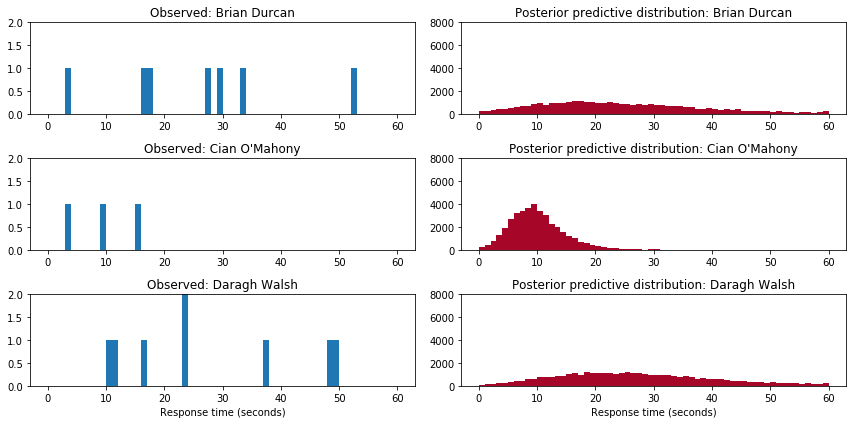

In [26]:
fig, axs = plt.subplots(3,2, figsize=(12, 6))
axs = axs.ravel()
y_left_max = 2
y_right_max = 8000
x_lim = 60
ix = [2,4,6]

for i, j, p in zip([0,1,2], [0,2,4], part[ix]):
    axs[j].set_title('Observed: %s' % p)
    axs[j].hist(messages[messages['prev_sender']==p]['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
    axs[j].set_ylim([0, y_left_max])

for i, j, p in zip([0,1,2], [1,3,5], part[ix]):
    axs[j].set_title('Posterior predictive distribution: %s' % p)
    axs[j].hist(indiv_traces[p].get_values('y_pred'), range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])
    axs[j].set_ylim([0, y_right_max])

axs[4].set_xlabel('Response time (seconds)')
axs[5].set_xlabel('Response time (seconds)')

plt.tight_layout()

The above plots show the observed data and the posterior predictive distribution for three sample conversations. The posterior predictive can vary considerably across conversations. This could accurately reflect the characteristics of the conversation or it could be inaccurate due to small sample size.

If we combine the posterior predictive distrobutions across these models, we could expect this to resemble the distribution of the overall dataset observed.

/home/gparkes/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


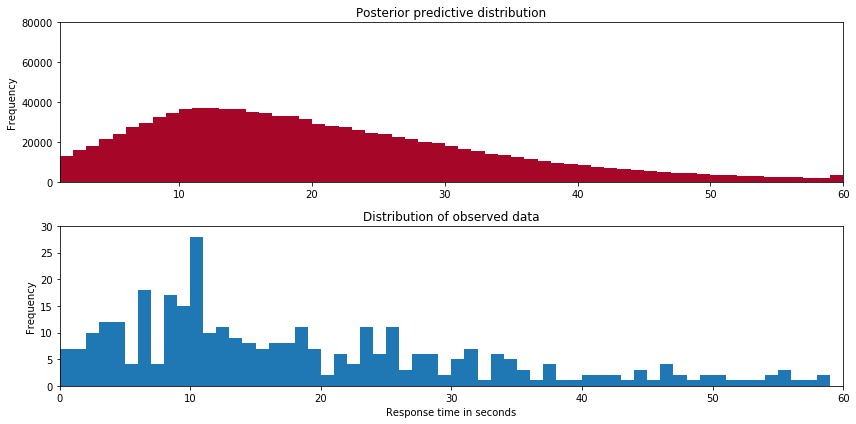

In [27]:
combined_y_pred = np.concatenate([v.get_values('y_pred') for k, v in indiv_traces.items()])

x_lim = 60
y_max = combined_y_pred.max()
y_pred = trace.get_values('y_pred')

fig = plt.figure(figsize=(12,6))
fig.add_subplot(211)

fig.add_subplot(211)

_ = plt.hist(combined_y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylim(0, 80000)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(messages['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlim(0, x_lim)
_ = plt.xlabel('Response time in seconds')
_ = plt.ylim(0, 30)
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

Now that the posterior predictive distribution resembles the distribution of the observed data. However there is concern that some of the conversations have very little data and hence the estimates are likely to have high variance. One way to mitigate this risk is to share information across conversations - but still estimate $\mu_i$ for each conversation. We call this **partial pooling**.

### Partial Pooling 

Just like in the pooled model, a partially pooled model has parameter values estimated for each conversation $i$. However, parameters are connected together via hyperparameters. This reflects our belief that my `response_time` per conversation have similarities with one another via my natural tendancy to respond either quickly or slowly. 

$$
y_{ji} \sim \text{NegBinomial}(\mu_i, \alpha_i)
$$

Following on from the above example, we will estimate parameter values $\mu_i$ and $\alpha_i$ for a Poisson distribution. Rather than using a uniform prior, I will use a Gamma distribution for both $\mu$ and $\sigma$. This will enable the introduction of more prior knowledge into the model as we have reasonable expectations as to what $\mu$ and $\sigma$ will be.

Here's the Gamma distribution $\Gamma$:

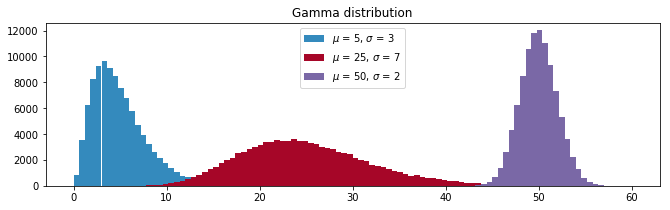

In [28]:
mu = [5,25,50]
sd = [3,7,2]

plt.figure(figsize=(11,3))
_ = plt.title('Gamma distribution')

with pm.Model() as model:
    for i, (j, k) in enumerate(zip(mu, sd)):
        samples = pm.Gamma('gamma_%s' % i, mu=j, sd=k).random(size=10**5)
        plt.hist(samples, bins=100, range=(0,60), color=colors[i], alpha=1)

_ = plt.legend(['$\mu$ = %s, $\sigma$ = %s' % (mu[a], sd[a]) for a in [0,1,2]])

The partially-pooled model can be formally described by:

$$
y_{ji} \sim \text{NegBinomial}(\mu_i, \alpha_i) \\
\mu_i \sim \Gamma(\mu_{\mu}, \sigma_{\mu}) \\
\alpha_i \sim \Gamma(\mu_{\alpha}, \sigma_{\alpha}) \\
\mu_{\mu} \sim \mathcal{U}(0, 60) \\
\sigma_{\mu} \sim \mathcal{U}(0, 50) \\
\mu_{\alpha} \sim \mathcal{U}(0, 10) \\
\sigma_{\alpha} \sim \mathcal{U}(0, 50) \\
$$

In [46]:
with pm.Model() as model:
    # hyperparameters
    # alpha params
    hyper_alpha_sd = pm.Uniform("hyper_alpha_sd", lower=0, upper=50)
    hyper_alpha_mu = pm.Uniform("hyper_alpha_mu", lower=0, upper=10)
    # mu params
    hyper_mu_sd = pm.Uniform("hyper_mu_sd", lower=0, upper=50)
    hyper_mu_mu = pm.Uniform("hyper_mu_mu", lower=0, upper=60)
    # prior params
    alpha = pm.Gamma("alpha", mu=hyper_alpha_mu, sd=hyper_alpha_sd, shape=n_part)
    mu = pm.Gamma("mu", mu=hyper_mu_mu, sd=hyper_mu_sd, shape=n_part)
    # likelihood
    y_est = pm.NegativeBinomial("y_est", mu=mu[part_idx], alpha=alpha[part_idx], observed=messages["time_delay_seconds"].values)
    y_pred = pm.NegativeBinomial("y_pred", mu=mu[part_idx], alpha=alpha[part_idx], shape=messages["prev_sender"].shape)
    # begin
    start = pm.find_MAP()
    step = pm.Metropolis()
    hierarchical_trace = pm.sample(20000, step, progressbar=True)

logp = -2,640.5, ||grad|| = 229.36: 100%|██████████| 190/190 [00:00<00:00, 1453.71it/s]        
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [y_pred]
>Metropolis: [mu]
>Metropolis: [alpha]
>Metropolis: [hyper_mu_mu]
>Metropolis: [hyper_mu_sd]
>Metropolis: [hyper_alpha_mu]
>Metropolis: [hyper_alpha_sd]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:46<00:00, 1752.73draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


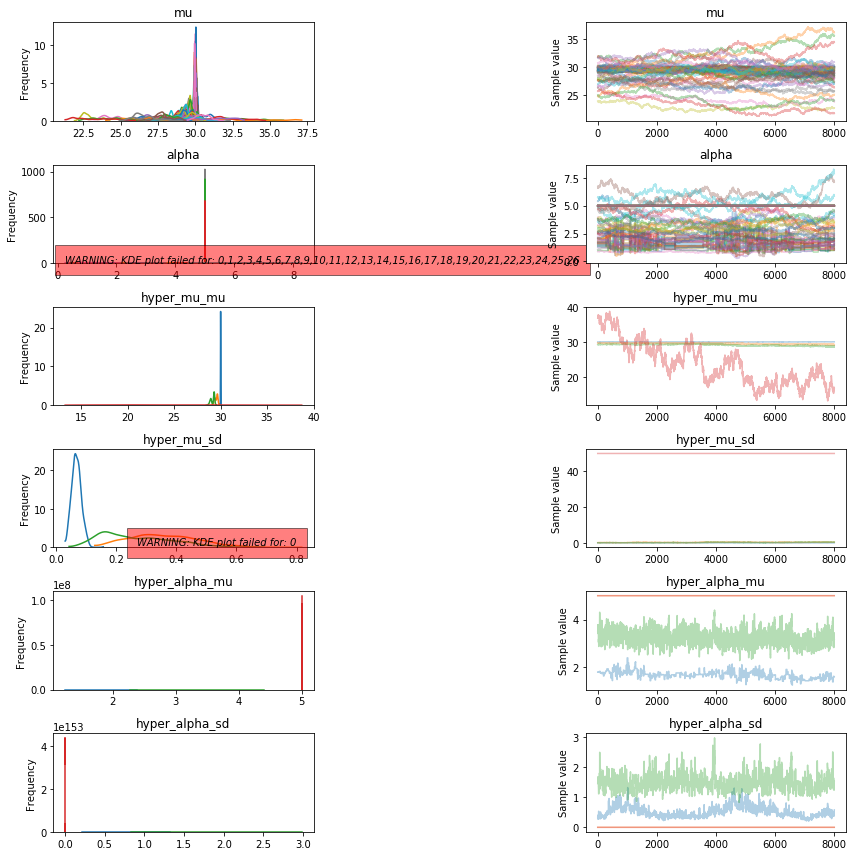

In [47]:
_ = pm.traceplot(hierarchical_trace[12000:], 
                 varnames=['mu','alpha','hyper_mu_mu',
                           'hyper_mu_sd','hyper_alpha_mu',
                           'hyper_alpha_sd'])

We can see for estimates of $\mu$ and $\alpha$ we have multiple plots - one for each conversation $i$. The difference between pooled and partially-pooled is that the parameters of the partially pooled model have a hyperparameter that is shared across all conversations $i$. This brings a number of benefits:

1. Information is shared across conversations, so for conversations that have limited sample size, they "borrow" knowledge from other conversations during estimation to help reduce the variance of the estimate.
2. We get an estimate for each conversation and an overall estimate for all conversations.



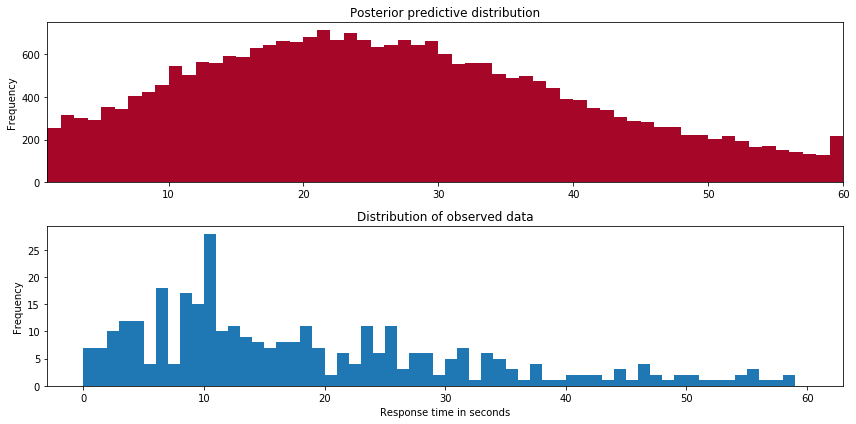

In [48]:
x_lim = 60
y_pred = hierarchical_trace.get_values('y_pred')[::1000].ravel()

fig = plt.figure(figsize=(12,6))

fig.add_subplot(211)

_ = plt.hist(y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(messages['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

## Shrinkage effort: pooled vs hierarchical model

As discussed, the partially pooled model shared a hyperparameter for both $\mu$ and $\alpha$. By sharing knowledge across conversations, it has the effect of shrinking the estimates closer together - particularly for conversations that have little data.

This shrinkage effect is illustrated in the below plot. You can see how the $\mu$
and $\alpha$ parameters are drawn together by the effect of the hyperparameter.

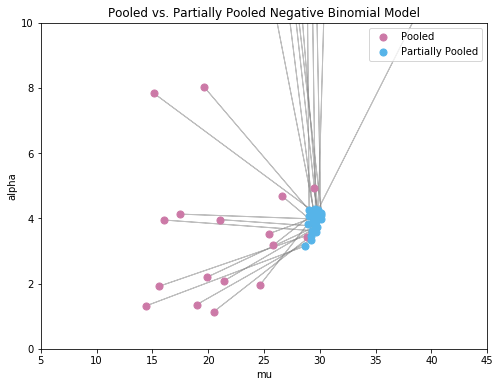

In [49]:
hier_mu = hierarchical_trace['mu'][500:].mean(axis=0)
hier_alpha = hierarchical_trace['alpha'][500:].mean(axis=0)
indv_mu = [indiv_traces[p]['mu'][500:].mean() for p in part]
indv_alpha = [indiv_traces[p]['alpha'][500:].mean() for p in part]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, xlabel='mu', ylabel='alpha', 
                     title='Pooled vs. Partially Pooled Negative Binomial Model', 
                     xlim=(5, 45), ylim=(0, 10))

ax.scatter(indv_mu, indv_alpha, c=colors[5], s=50, label = 'Pooled', zorder=3)
ax.scatter(hier_mu, hier_alpha, c=colors[6], s=50, label = 'Partially Pooled', zorder=4)
for i in range(len(indv_mu)):  
    ax.arrow(indv_mu[i], indv_alpha[i], hier_mu[i] - indv_mu[i], hier_alpha[i] - indv_alpha[i], 
            fc="grey", ec="grey", length_includes_head=True, alpha=.5, head_width=0)

_ = ax.legend()

## Asking questions of the posterior

Let's start to take advantage of one of the best aspects of Bayesian statistics - the posterior distribution. Unlike frequentist techniques, we get a full posterior distribution as opposed to a single point estimate. In essence, we have a basket full of credible parameter values. This enables us to ask some questions in a fairly natural and intuitive manner.